# Question 3: Is it possible to predict rates per night and person of Airbnb listings in Berlin?
The third question around the Airbnb Berlin data set is about the possibility to predict rates per night and person for Airbnb homes in Berlin. The steps involved in answering the question are as follows:
* Load Libraries
* Import Data Set
* Pre-Processing
* Analyze Data Set & Evaluate Results


Compare
* Rates
* Income
* Competition
** Listings Count
** Number of Bookings
** Rating

## Load Libraries

In [87]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import folium

%matplotlib inline

## Import Data Set

In [144]:
# Import listings data
# Source: http://insideairbnb.com/get-the-data.html
df_listings = pd.read_csv('/Users/patrick.peltier/Documents/Udacity Data Science Nanodegree/Data/Airbnb/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20180912025131,2018-09-12,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,6 weeks ago,t,5,34,64,154,2018-09-12,109,2016-04-11,2018-09-08,92.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,3.69


## Pre-Processing

In [145]:
# Check distriutions of property types
property_count = df_listings["property_type"].value_counts().sum()
(df_listings["property_type"].value_counts().sort_values(ascending=False) / property_count).head()

Apartment             0.900097
Condominium           0.026715
Loft                  0.018740
House                 0.018120
Serviced apartment    0.008462
Name: property_type, dtype: float64

In [146]:
# Keep only apartments in analysis (~ 90% of listings)
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2255 records were removed from the Airbnb Berlin listings data frame.


In [171]:
# Cast "host_respose_rate" column to float
df_listings["host_response_rate"] = df_listings["host_response_rate"].astype(str)
df_listings["host_response_rate"] = df_listings["host_response_rate"].apply(lambda x: x.replace('%','').replace(',',''))
df_listings["host_response_rate"] = df_listings["host_response_rate"].astype(float)

# Summary statistics
df_listings["host_response_rate"].describe()

count    10898.000000
mean        91.381354
std         19.015855
min          0.000000
25%         90.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: host_response_rate, dtype: float64

In [148]:
# Convert price columns used in calculation to float
price_cols = ["price","weekly_price","monthly_price","cleaning_fee","extra_people"]

for col in price_cols:
    df_listings[col] = df_listings[col].astype(str)
    df_listings[col] = df_listings[col].apply(lambda x: x.replace('$','').replace(',',''))
    df_listings[col] = df_listings[col].astype(float)

df_listings["cleaning_fee"] = df_listings["cleaning_fee"].fillna(0)
df_listings["extra_people"] = df_listings["extra_people"].fillna(0)

In [149]:
# Remove all records where "accommodates" < "guest_included" as this shouldn't be possible
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["accommodates"] >= df_listings["guests_included"]]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

95 records were removed from the Airbnb Berlin listings data frame.


In [150]:
# Create "price_per_person" column (based on total number of possible guests)
df_listings["price_per_person"] = ((
    df_listings["price"] + df_listings["cleaning_fee"] +
    df_listings["extra_people"] * (df_listings["accommodates"] - df_listings["guests_included"]))
    /
    df_listings["guests_included"])

Only from looking at the summary statistics we can already see that some hosts in Berlin seem to rent out their places almost for free while others seem to charge prices way beyond average. The introduction of __"price_per_person" shows that none of the offered places comes completely free of charge__ as at least cleaning fees and extra people lead to some sort of costs (compare min values for "price" and "price_per_person").

In [151]:
# Column "reviews_per_month" can only be used as proxy for booking frequency if it doesn't
# exceed to the maximum availability per month

# Fill missing values with 0
df_listings["reviews_per_month"] = df_listings["reviews_per_month"].fillna(0)

# Define adjusted proxy for number of bookings per months
df_listings["max_bookings_per_month"] = (30.42 / df_listings["minimum_nights"]).fillna(0)
df_listings["bookings_per_month"] = df_listings[["max_bookings_per_month","reviews_per_month"]].min(axis=1)
df_listings = df_listings.drop("max_bookings_per_month", axis=1)

df_listings["bookings_per_month"].describe()

count    20222.000000
mean         0.887144
std          1.339041
min          0.000000
25%          0.060000
50%          0.330000
75%          1.080000
max         14.790000
Name: bookings_per_month, dtype: float64

In [152]:
# Calculate each listing's income per booking
booking_income = []

for (p,wp,mp,n) in zip(df_listings["price"], df_listings["weekly_price"], df_listings["monthly_price"], df_listings["minimum_nights"]):
    price = 0.0
    if n > 29:
        if not math.isnan(mp):
            months = n / 30.0
            price += mp * math.floor(months)
            if not math.isnan(wp):
                weeks = ((months - math.floor(months)) * 30.0) / 7.0
                days = (weeks - math.floor(weeks)) * 7.0
                price += (wp * math.floor(weeks)) + (n * days)
            else:
                days = (months - math.floor(months)) * 30.0
                price += p * days
        elif not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    elif n > 6:
        if not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    else:
        price += p * n
    
    booking_income.append(price)

# Add to data frame
df_listings["income_per_booking"] = booking_income
df_listings["income_per_booking"].describe()

count     20222.000000
mean        423.703442
std        6723.631286
min           0.000000
25%          60.000000
50%         120.000000
75%         246.000000
max      900000.000000
Name: income_per_booking, dtype: float64

In [153]:
# As on booking can span over multiple months we need to convert the price per booking
# to a price per months before multiplying it with the number of reviews per month
df_listings["income_per_month"] = df_listings["income_per_booking"] * df_listings["bookings_per_month"]
df_listings["income_per_month"].describe()

count    20222.000000
mean       162.603665
std        415.259097
min          0.000000
25%          6.000000
50%         44.100000
75%        160.000000
max      27000.000000
Name: income_per_month, dtype: float64

In [154]:
# Remove upper 5% from data set
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["income_per_month"] <= df_listings["income_per_month"].quantile(.95)]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

1012 records were removed from the Airbnb Berlin listings data frame.


## Analyses

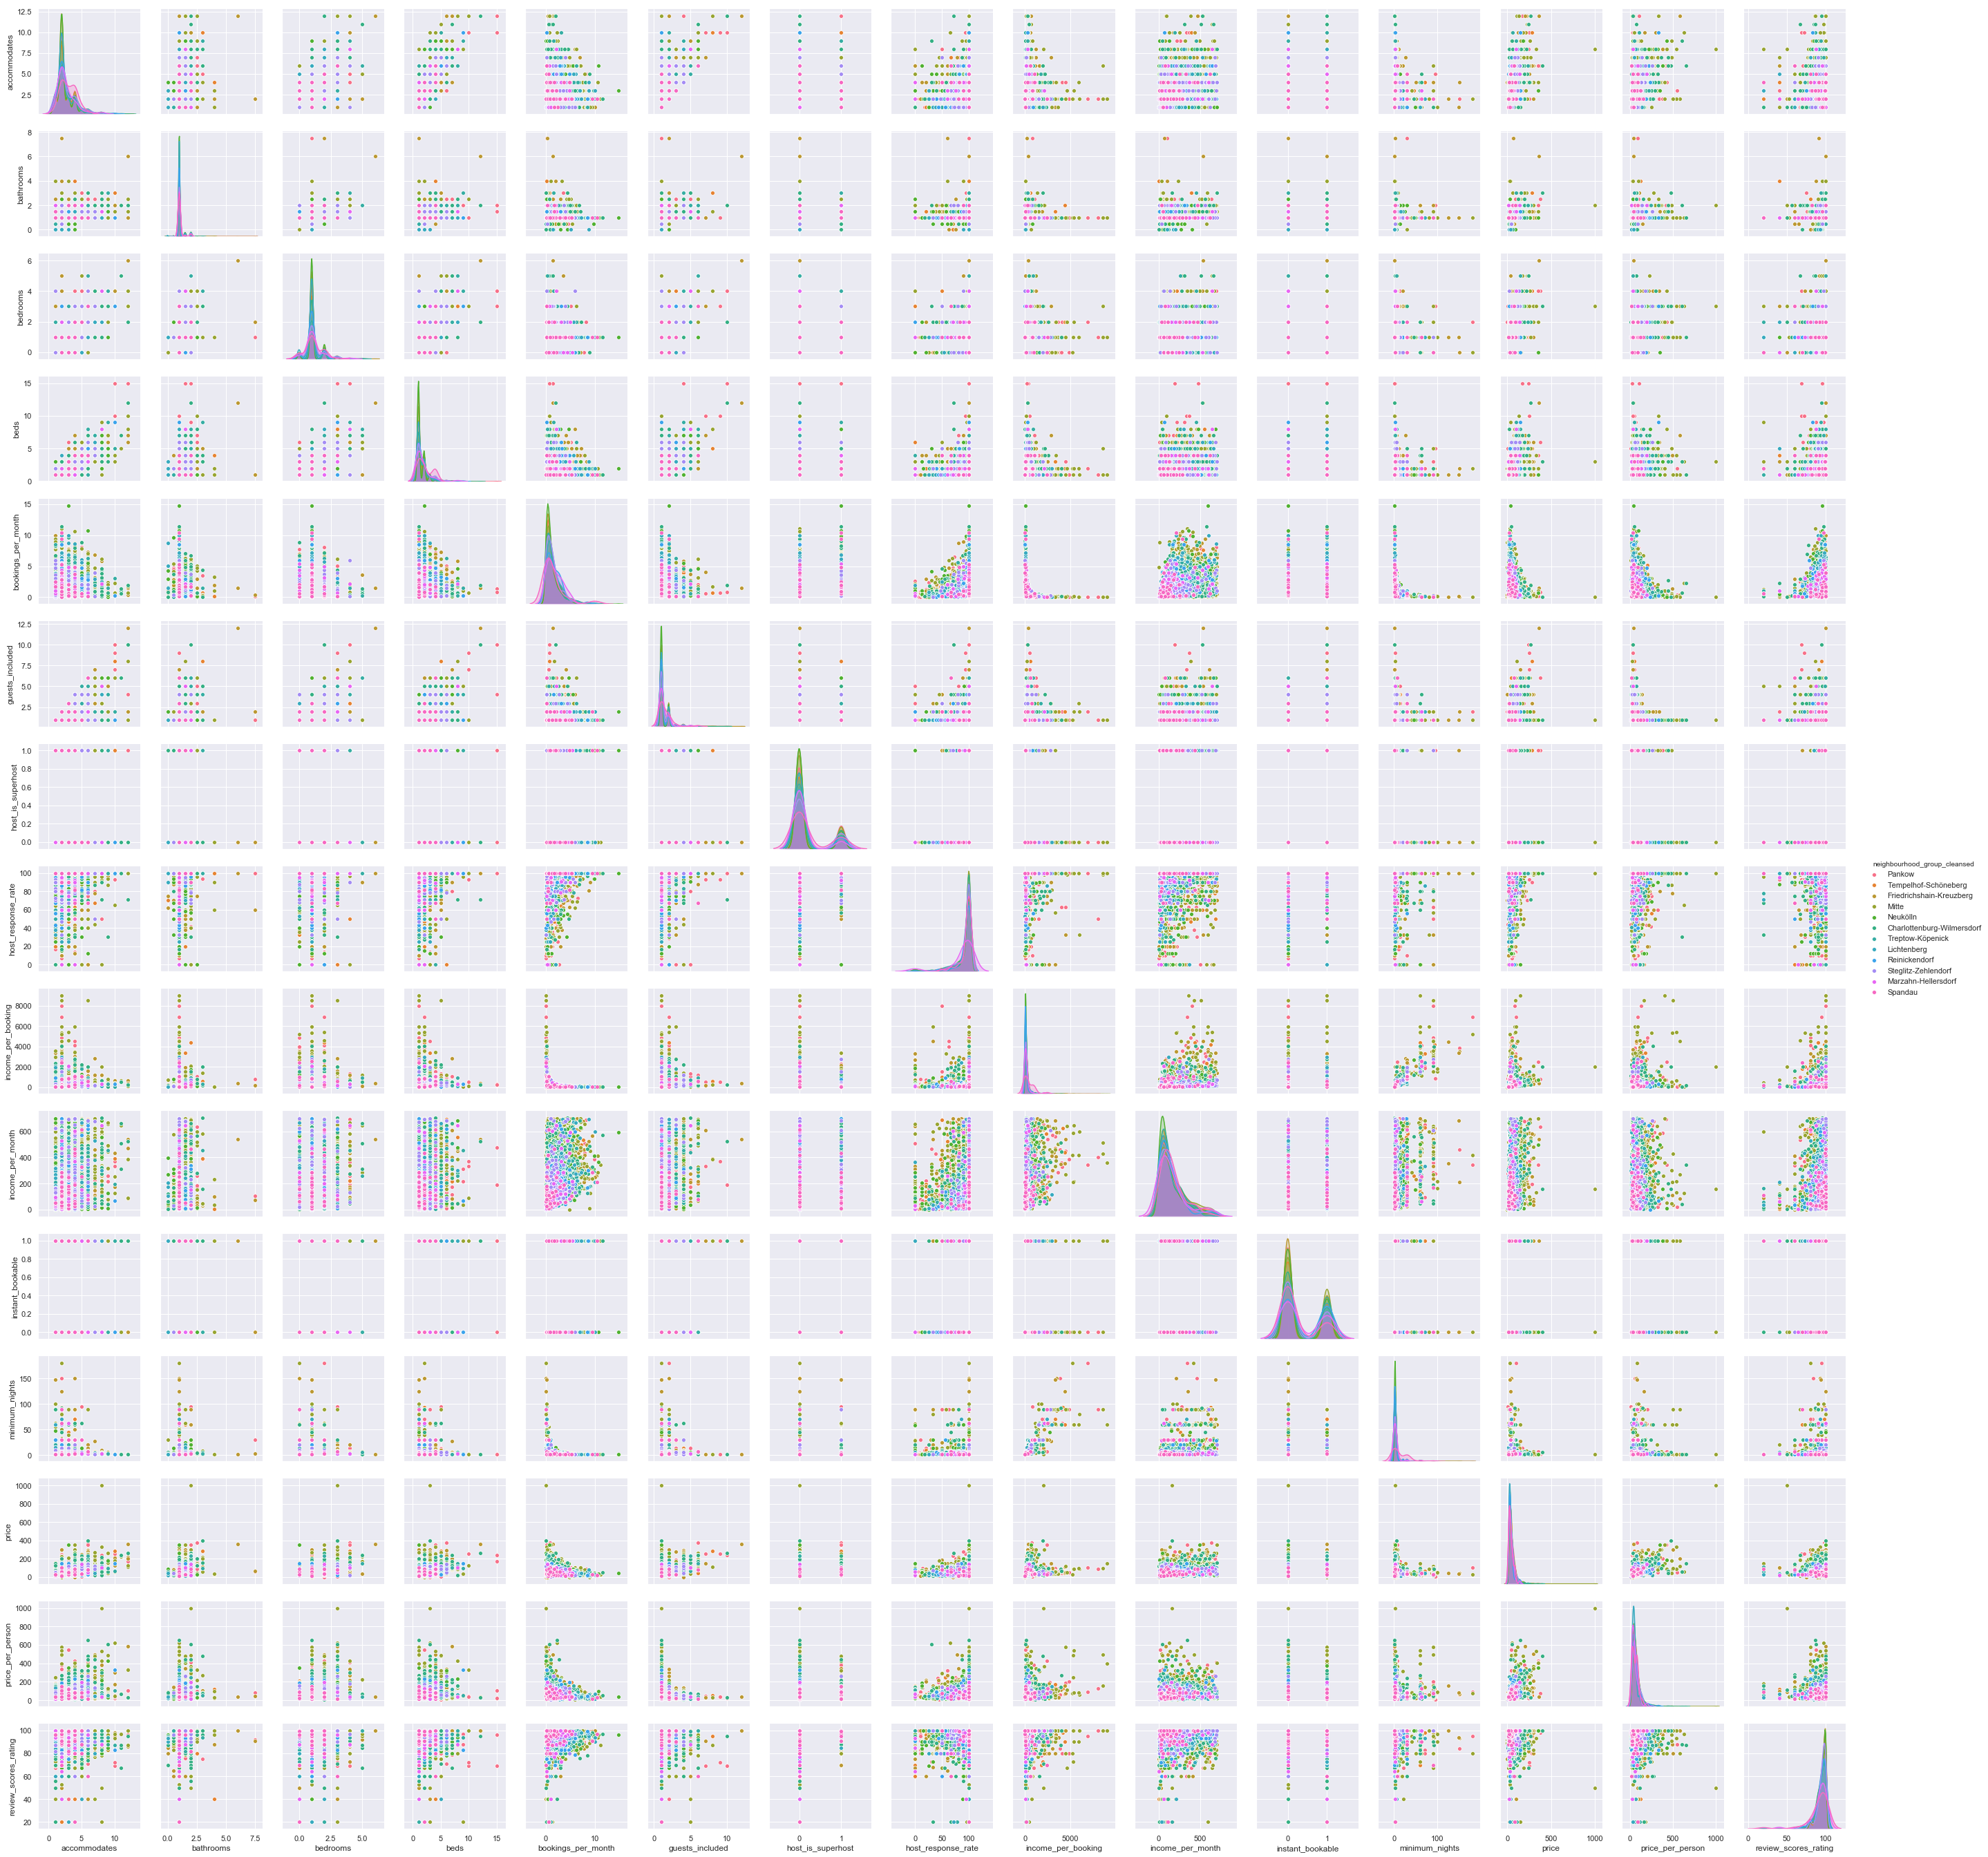

In [174]:
# Pairplot of subset of columns
pair_cols = sorted(["accommodates","guests_included","bathrooms","bedrooms","beds","price","minimum_nights",
                    "bookings_per_month","income_per_booking","income_per_month","review_scores_rating",
                    "instant_bookable","host_is_superhost","price_per_person","host_response_rate",
                    "neighbourhood_group_cleansed"])

g = sns.pairplot(df_listings[pair_cols].dropna(axis=0), hue="neighbourhood_group_cleansed")

Pairplot seems a little bit too overwhelming to find correlations between columns in the data set and a listing's income per month.

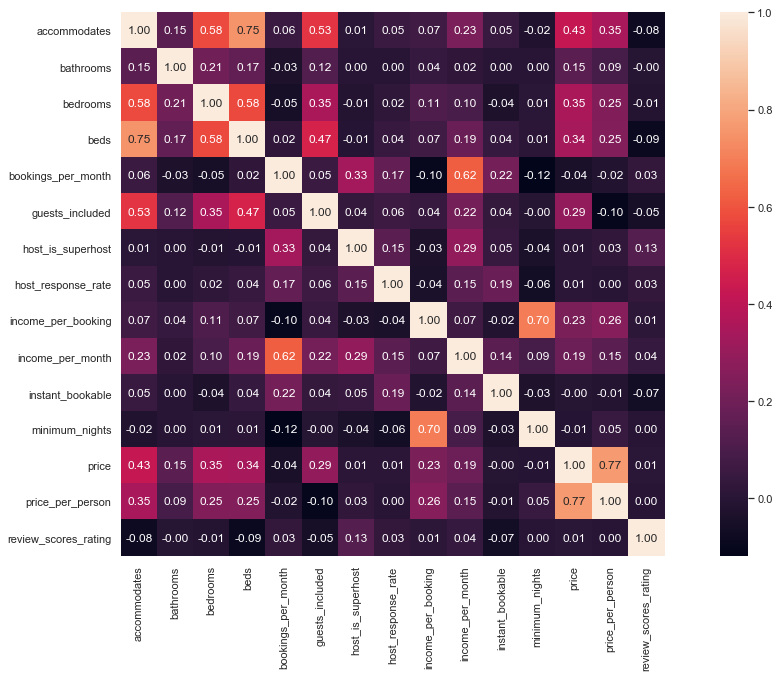

In [173]:
# Correlation Plot
corr_cols = sorted(["accommodates","guests_included","bathrooms","bedrooms","beds","price","minimum_nights",
                    "bookings_per_month","income_per_booking","income_per_month","review_scores_rating",
                    "instant_bookable","host_is_superhost","price_per_person","host_response_rate"])
corrs = df_listings[corr_cols].corr()
plt.subplots(figsize=(20,10))
sns.set(font_scale=1)
sns.heatmap(corrs, yticklabels=corr_cols, xticklabels=corr_cols, cbar=True, annot=True, square=True, fmt=".2f");

In [162]:
# Adjust values of "neighbourhood_group_cleansed" (needs to be in correct form for later use)
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace(" ", "")

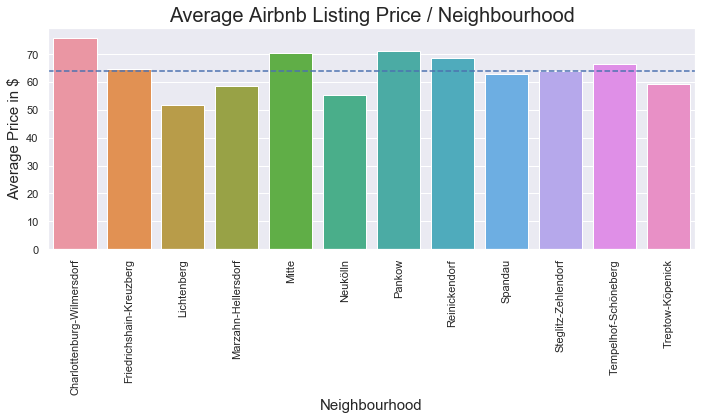

In [163]:
# Average price per person / neighbourhood
prices_neighbourhood = df_listings[["neighbourhood_group_cleansed", "price_per_person"]]
prices_neighbourhood = prices_neighbourhood.groupby("neighbourhood_group_cleansed", as_index=False).mean()
prices_neighbourhood.columns = ["neighbourhood_group", "price_per_person"]
prices_neighbourhood = prices_neighbourhood.sort_values("neighbourhood_group")

# Plot
plt.subplots(figsize=(10,6))
sns.set(style="darkgrid")
ax = sns.barplot(x="neighbourhood_group", y="price_per_person", data=prices_neighbourhood)
plt.xticks(rotation=90);
plt.title("Average Airbnb Listing Price / Neighbourhood", fontsize=20)
plt.ylabel("Average Price in $", fontsize=15)
plt.xlabel("Neighbourhood", fontsize=15)
plt.tight_layout()

# Add median as reference line
ax.axhline(prices_neighbourhood["price_per_person"].mean(), ls='--');

In [164]:
# Load geojson object
# Source:
# https://data.technologiestiftung-berlin.de/dataset/bezirksgrenzen
berlin_hoods = os.path.join("../data/berlin_neighbourhood_groups.geojson")
geo_json_data = json.load(open(berlin_hoods))

In [165]:
# Create income dictionary
price_dict = prices_neighbourhood.set_index("neighbourhood_group")["price_per_person"]
price_dict["Mitte"]

70.32181167707694

In [178]:
# Draw choropleth map (let folium determine the scale)
hood_map = folium.Map(location=[52.534537, 13.402557], zoom_start=11)
hood_map.choropleth(geo_data=geo_json_data, data=price_dict,
                    key_on="feature.properties.Gemeinde_name",
                    fill_color="OrRd", fill_opacity=0.7, line_opacity=0.2,
                    legend_name="Airbnb Listing Prices Per Person in $")

hood_map.save("../data/airbnb_prices_neighbourhoods.html")
hood_map